# imports

Note: if you want to run this, this should be in the metric_depth folder of the depth_anything v2 github

In [1]:
import numpy as np
import torch
from depth_anything_v2.dpt import DepthAnythingV2

print("NumPy version:", np.__version__)
print("Torch version:", torch.__version__)
print("Model class loaded:", DepthAnythingV2)

xFormers not available
xFormers not available


NumPy version: 1.26.4
Torch version: 2.2.2
Model class loaded: <class 'depth_anything_v2.dpt.DepthAnythingV2'>


In [2]:
import cv2
print("OpenCV:", cv2.__version__)

from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

OpenCV: 4.9.0


# Setting up folders

In [3]:
# Where we are (notebook inside metric_depth)
METRIC_DIR = Path(".").resolve()
REPO_ROOT = METRIC_DIR.parent

# Make sure Python can see the package at repo root
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print("METRIC_DIR:", METRIC_DIR)
print("REPO_ROOT:", REPO_ROOT)

# DEVICE = "cuda" if torch.cuda.is_available() else (
#     "mps" if torch.backends.mps.is_available() else "cpu"
# )
torch.cuda.is_available = lambda *args, **kwargs: False
torch.backends.mps.is_available = lambda *args, **kwargs: False

DEVICE = "cpu"
print("Using device:", DEVICE)

# Output dirs for your experiment artifacts
PROJECT_OUTPUT_ROOT = METRIC_DIR / "demo_outputs"
RAW_OUTPUT_DIR = PROJECT_OUTPUT_ROOT / "raw_depth_outputs"
CSV_OUTPUT_DIR = PROJECT_OUTPUT_ROOT / "raw_depth_csv"
VIS_OUTPUT_DIR = PROJECT_OUTPUT_ROOT / "visualizations"

for d in [PROJECT_OUTPUT_ROOT, RAW_OUTPUT_DIR, CSV_OUTPUT_DIR, VIS_OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Your test images — put them in metric_depth/data/
TEST_IMAGE_DIR = METRIC_DIR / "test_data"
TEST_IMAGES = sorted(
    list(TEST_IMAGE_DIR.glob("*.png")) + list(TEST_IMAGE_DIR.glob("*.jpg"))
)
print("Found test images:", [p.name for p in TEST_IMAGES])

METRIC_DIR: /Users/aidanwen/Documents/Depth-Anything-V2/metric_depth
REPO_ROOT: /Users/aidanwen/Documents/Depth-Anything-V2
Using device: cpu
Found test images: ['frame_000.png', 'frame_001.png', 'frame_002.png', 'frame_003.png', 'frame_004.png', 'image_20241105_071643.png']


# Loading the models

In [18]:
# Encoder configs from Depth Anything V2 docs
DA_ENCODER_CONFIGS = {
    "vits": {"encoder": "vits", "features": 64, "out_channels": [48, 96, 192, 384]},
    "vitb": {"encoder": "vitb", "features": 128, "out_channels": [96, 192, 384, 768]},
    "vitl": {"encoder": "vitl", "features": 256, "out_channels": [256, 512, 1024, 1024]},
}

# 2 smallest indoor + 2 smallest outdoor
MODEL_CONFIGS = [
    {
        "name": "metric_small_indoor",   # Depth-Anything-V2-Small on Hypersim
        "encoder": "vits",
        "dataset": "hypersim",
        "max_depth": 20,                 # indoor metric range in meters
    },
    {
        "name": "metric_base_indoor",    # Depth-Anything-V2-Base on Hypersim
        "encoder": "vitb",
        "dataset": "hypersim",
        "max_depth": 80,
    },
    {
        "name": "metric_small_outdoor",  # Depth-Anything-V2-Small on VKITTI2
        "encoder": "vits",
        "dataset": "vkitti",
        "max_depth": 80,                 # outdoor metric range in meters
    },
    {
        "name": "metric_base_outdoor",   # Depth-Anything-V2-Base on VKITTI2
        "encoder": "vitb",
        "dataset": "vkitti",
        "max_depth": 80,
    },
]


def load_depth_model(encoder: str, dataset: str, max_depth: float):
    """
    Load a Depth Anything V2 metric model
    """
    if encoder not in DA_ENCODER_CONFIGS:
        raise ValueError(f"Unknown encoder '{encoder}'")

    cfg = DA_ENCODER_CONFIGS[encoder]

    ckpt_path = METRIC_DIR / "checkpoints" / f"depth_anything_v2_metric_{dataset}_{encoder}.pth"
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    print(f"Loading {ckpt_path}")
    model = DepthAnythingV2(**{**cfg, "max_depth": max_depth})
    state = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(state)
    model = model.to(DEVICE).eval()
    return model


## Helper Functions

In [19]:
def preprocess_image(image_path: Path):
    """
    For now, just load it in
    """
    raw_img = cv2.imread(str(image_path))
    if raw_img is None:
        raise ValueError(f"Failed to read image at {image_path}")
    return raw_img


def mask_bottom_region(raw_img: np.ndarray, fraction: float = 0.25):
    """
    Black out the bottom fraction of the image (0–1).
    returns a copy.
    """
    h, w, c = raw_img.shape
    masked = raw_img.copy()
    cutoff = int(h * (1.0 - fraction))
    masked[cutoff:, :, :] = 0  # set bottom region to black
    return masked


# Testing

In [20]:
model_config = MODEL_CONFIGS[1] # 3 = outdoor medium, 1 = indoor medium

print("Using config:")
for k, v in model_config.items():
    print(f"  {k}: {v}")

current_model_name = model_config["name"]
current_encoder    = model_config["encoder"]
current_dataset    = model_config["dataset"]
current_max_depth  = model_config["max_depth"]

current_model = load_depth_model(
    encoder=current_encoder,
    dataset=current_dataset,
    max_depth=current_max_depth,
)

print(f"\nLoaded model '{current_model_name}' with encoder='{current_encoder}', dataset='{current_dataset}'")

Using config:
  name: metric_base_indoor
  encoder: vitb
  dataset: hypersim
  max_depth: 80
Loading /Users/aidanwen/Documents/Depth-Anything-V2/metric_depth/checkpoints/depth_anything_v2_metric_hypersim_vitb.pth

Loaded model 'metric_base_indoor' with encoder='vitb', dataset='hypersim'


In [21]:
RAW_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for img_path in TEST_IMAGES:
    img_name = img_path.stem
    print(f"\n[{current_model_name}] Processing image: {img_name}")

    # Load the image (no blackout, no modification)
    raw_img = preprocess_image(img_path)
    if raw_img is None:
        raise ValueError(f"Failed to read image: {img_path}")

    # Run the model: this is the ONLY place depth is produced
    depth = current_model.infer_image(raw_img)   # H x W depth (meters), NumPy
    depth_np = np.array(depth, copy=True)        # explicit copy, no changes

    print(
        "  depth shape:", depth_np.shape,
        "min:", float(depth_np.min()),
        "max:", float(depth_np.max()),
        "mean:", float(depth_np.mean()),
    )

    # Save exact raw outputs (no post-processing)
    npy_path = RAW_OUTPUT_DIR / f"{img_name}__{current_model_name}.npy"
    csv_path = CSV_OUTPUT_DIR / f"{img_name}__{current_model_name}.csv"

    np.save(npy_path, depth_np)
    pd.DataFrame(depth_np).to_csv(csv_path, index=False)

    print("  Saved:", npy_path.name)
    print("  Saved:", csv_path.name)


[metric_base_indoor] Processing image: frame_000
  depth shape: (1544, 2064) min: 2.9617910385131836 max: 79.91719818115234 mean: 38.1749382019043
  Saved: frame_000__metric_base_indoor.npy
  Saved: frame_000__metric_base_indoor.csv

[metric_base_indoor] Processing image: frame_001
  depth shape: (1544, 2064) min: 2.8940646648406982 max: 79.92591094970703 mean: 37.847999572753906
  Saved: frame_001__metric_base_indoor.npy
  Saved: frame_001__metric_base_indoor.csv

[metric_base_indoor] Processing image: frame_002
  depth shape: (1544, 2064) min: 2.9531421661376953 max: 79.91951751708984 mean: 38.172119140625
  Saved: frame_002__metric_base_indoor.npy
  Saved: frame_002__metric_base_indoor.csv

[metric_base_indoor] Processing image: frame_003
  depth shape: (1544, 2064) min: 2.860564947128296 max: 79.93184661865234 mean: 38.24367141723633
  Saved: frame_003__metric_base_indoor.npy
  Saved: frame_003__metric_base_indoor.csv

[metric_base_indoor] Processing image: frame_004
  depth shape

## Visualizations

Available saved results for this model:
  - frame_000__metric_base_indoor.npy
  - frame_000_mask43__metric_base_indoor.npy
  - frame_001__metric_base_indoor.npy
  - frame_001_mask43__metric_base_indoor.npy
  - frame_002__metric_base_indoor.npy
  - frame_002_mask43__metric_base_indoor.npy
  - frame_003__metric_base_indoor.npy
  - frame_003_mask43__metric_base_indoor.npy
  - frame_004__metric_base_indoor.npy
  - frame_004_mask43__metric_base_indoor.npy
  - image_20241105_071643__metric_base_indoor.npy
  - image_20241105_071643_mask43__metric_base_indoor.npy

Visualizing: frame_000__metric_base_indoor.npy
Raw depth stats:
  shape: (1544, 2064)
  min  : 2.9617910385131836
  max  : 79.91719818115234
  mean : 38.1749382019043


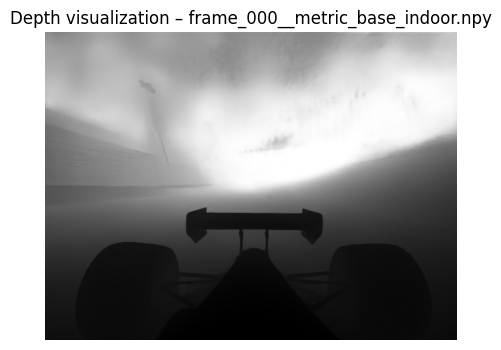

In [22]:
# --- Visualization: grayscale depth for the current model (read-only) ---

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# 1) List all saved .npy files for this model
saved_npy_files = sorted(RAW_OUTPUT_DIR.glob(f"*__{current_model_name}.npy"))
if not saved_npy_files:
    raise RuntimeError(f"No .npy files found in {RAW_OUTPUT_DIR} for model '{current_model_name}'")

print("Available saved results for this model:")
for p in saved_npy_files:
    print("  -", p.name)

# 2) Pick one file to visualize (here we just take the first one; you can change index)
example_npy = saved_npy_files[0]
print("\nVisualizing:", example_npy.name)

# 3) Load the raw depth map from disk (this is the *exact* saved output)
depth_raw = np.load(example_npy)  # shape (H, W), values in meters

print("Raw depth stats:")
print("  shape:", depth_raw.shape)
print("  min  :", float(depth_raw.min()))
print("  max  :", float(depth_raw.max()))
print("  mean :", float(depth_raw.mean()))

# 4) Create a *separate copy* for visualization so we never modify depth_raw
depth_vis = depth_raw.astype(np.float32).copy()

# Optional: percentile clipping to reduce outlier influence (purely for display)
clip_percentile = 1.0  # you can adjust this if needed
low = np.percentile(depth_vis, clip_percentile)
high = np.percentile(depth_vis, 100 - clip_percentile)
depth_vis = np.clip(depth_vis, low, high)

# 5) Min-max normalize the visualization copy to [0, 1] for grayscale display
dmin, dmax = float(depth_vis.min()), float(depth_vis.max())
if dmax > dmin:
    depth_norm = (depth_vis - dmin) / (dmax - dmin)
else:
    depth_norm = np.zeros_like(depth_vis, dtype=np.float32)

# 6) Show the grayscale image
plt.figure(figsize=(6, 4))
plt.title(f"Depth visualization – {example_npy.name}")
plt.imshow(depth_norm, cmap="gray")
plt.axis("off")
plt.show()

In [23]:
# --- Create 43% masked base images (racecar hidden) ---

MASK_FRACTION = 0.43  # bottom 43% of the image will be blacked out

# Output folder for filtered images
FILTERED_DATA_DIR = METRIC_DIR / f"data_masked_{int(MASK_FRACTION * 100)}"
FILTERED_DATA_DIR.mkdir(parents=True, exist_ok=True)
print("Filtered images will be saved to:", FILTERED_DATA_DIR)

# If you already defined this earlier, you can skip this function and reuse yours.
def mask_bottom_region(raw_img, fraction: float):
    """
    Black out the bottom `fraction` (0–1) of the image.
    Works on a copy; does not modify the input array in place.
    """
    h, w, c = raw_img.shape
    masked = raw_img.copy()
    cutoff = int(h * (1.0 - fraction))
    masked[cutoff:, :, :] = 0  # black rectangle over bottom part
    return masked

saved_paths = []

for img_path in TEST_IMAGES:
    img = cv2.imread(str(img_path))
    if img is None:
        print("Skipping unreadable image:", img_path)
        continue

    # Apply masking
    masked = mask_bottom_region(img, fraction=MASK_FRACTION)

    # Save alongside original name, with suffix indicating masking
    out_name = f"{img_path.stem}_mask{int(MASK_FRACTION * 100)}{img_path.suffix}"
    out_path = FILTERED_DATA_DIR / out_name
    cv2.imwrite(str(out_path), masked)
    saved_paths.append(out_path)
    print("Saved filtered image:", out_path.name)

# Optional: a list of masked images you can use later as TEST_IMAGES for masked runs
TEST_IMAGES_MASKED_43 = sorted(saved_paths)
print(f"\nTotal filtered images saved: {len(TEST_IMAGES_MASKED_43)}")


Filtered images will be saved to: /Users/aidanwen/Documents/Depth-Anything-V2/metric_depth/data_masked_43
Saved filtered image: frame_000_mask43.png
Saved filtered image: frame_001_mask43.png
Saved filtered image: frame_002_mask43.png
Saved filtered image: frame_003_mask43.png
Saved filtered image: frame_004_mask43.png
Saved filtered image: image_20241105_071643_mask43.png

Total filtered images saved: 6


In [24]:
# --- Run current_model on 43%-masked images and save raw outputs ---

from pathlib import Path
import numpy as np
import pandas as pd

print("Running model on masked images:")
print("  model:", current_model_name)
print("  num masked images:", len(TEST_IMAGES_MASKED_43))

RAW_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for img_path in TEST_IMAGES_MASKED_43:
    img_name = img_path.stem  # e.g., "frame_000_mask43"
    print(f"\n[{current_model_name}] Processing masked image: {img_name}")

    # Load the masked image (no further modifications)
    raw_img = cv2.imread(str(img_path))
    if raw_img is None:
        raise ValueError(f"Failed to read masked image: {img_path}")

    # Run model: this is the ONLY place depth is produced
    depth = current_model.infer_image(raw_img)
    depth_np = np.array(depth, copy=True)

    print(
        "  depth shape:", depth_np.shape,
        "min:", float(depth_np.min()),
        "max:", float(depth_np.max()),
        "mean:", float(depth_np.mean()),
    )

    # Save exact raw outputs, note the img_name already encodes mask43
    npy_path = RAW_OUTPUT_DIR / f"{img_name}__{current_model_name}.npy"
    csv_path = CSV_OUTPUT_DIR / f"{img_name}__{current_model_name}.csv"

    np.save(npy_path, depth_np)
    pd.DataFrame(depth_np).to_csv(csv_path, index=False)

    print("  Saved:", npy_path.name)
    print("  Saved:", csv_path.name)


Running model on masked images:
  model: metric_base_indoor
  num masked images: 6

[metric_base_indoor] Processing masked image: frame_000_mask43
  depth shape: (1544, 2064) min: 4.739751815795898 max: 79.90402221679688 mean: 38.48025894165039
  Saved: frame_000_mask43__metric_base_indoor.npy
  Saved: frame_000_mask43__metric_base_indoor.csv

[metric_base_indoor] Processing masked image: frame_001_mask43
  depth shape: (1544, 2064) min: 4.866145133972168 max: 79.92564392089844 mean: 38.86271286010742
  Saved: frame_001_mask43__metric_base_indoor.npy
  Saved: frame_001_mask43__metric_base_indoor.csv

[metric_base_indoor] Processing masked image: frame_002_mask43
  depth shape: (1544, 2064) min: 4.889507293701172 max: 79.91547393798828 mean: 39.15268325805664
  Saved: frame_002_mask43__metric_base_indoor.npy
  Saved: frame_002_mask43__metric_base_indoor.csv

[metric_base_indoor] Processing masked image: frame_003_mask43
  depth shape: (1544, 2064) min: 4.833175182342529 max: 79.90053558

In [25]:
# --- Save grayscale visualizations for all .npy of the current model (read-only on depth) ---

import matplotlib.pyplot as plt

# Collect all raw depth maps for this model (both masked and unmasked if they exist)
model_npy_files = sorted(RAW_OUTPUT_DIR.glob(f"*__{current_model_name}.npy"))
if not model_npy_files:
    raise RuntimeError(f"No .npy files found for model '{current_model_name}' in {RAW_OUTPUT_DIR}")

print(f"Found {len(model_npy_files)} depth maps for model '{current_model_name}'")
print("Saving grayscale PNGs to:", VIS_OUTPUT_DIR)

# Option: use a shared percentile clip per model to keep visualization consistent
clip_percentile = 1.0

# First pass: gather all values for clipping across this model's maps
all_values = []
for npy_path in model_npy_files:
    depth_raw = np.load(npy_path).astype(np.float32)
    all_values.append(depth_raw.flatten())
all_values = np.concatenate(all_values)
low = np.percentile(all_values, clip_percentile)
high = np.percentile(all_values, 100 - clip_percentile)

print("Visualization clipping range (per model):")
print("  low :", float(low))
print("  high:", float(high))

# Second pass: save per-image PNGs
for npy_path in model_npy_files:
    depth_raw = np.load(npy_path).astype(np.float32)

    # Work on a copy for visualization only
    depth_vis = np.clip(depth_raw, low, high)

    dmin, dmax = float(depth_vis.min()), float(depth_vis.max())
    if dmax > dmin:
        depth_norm = (depth_vis - dmin) / (dmax - dmin)
    else:
        depth_norm = np.zeros_like(depth_vis, dtype=np.float32)

    # Construct output name: just swap ".npy" for "_gray.png"
    out_name = npy_path.name.replace(".npy", "_gray.png")
    out_path = VIS_OUTPUT_DIR / out_name

    plt.figure(figsize=(6, 4))
    plt.imshow(depth_norm, cmap="gray")
    plt.axis("off")
    plt.title(npy_path.name)
    plt.savefig(out_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    print("Saved visualization:", out_path.name)


Found 12 depth maps for model 'metric_base_indoor'
Saving grayscale PNGs to: /Users/aidanwen/Documents/Depth-Anything-V2/metric_depth/demo_outputs/visualizations
Visualization clipping range (per model):
  low : 3.338037574291229
  high: 79.53437042236328
Saved visualization: frame_000__metric_base_indoor_gray.png
Saved visualization: frame_000_mask43__metric_base_indoor_gray.png
Saved visualization: frame_001__metric_base_indoor_gray.png
Saved visualization: frame_001_mask43__metric_base_indoor_gray.png
Saved visualization: frame_002__metric_base_indoor_gray.png
Saved visualization: frame_002_mask43__metric_base_indoor_gray.png
Saved visualization: frame_003__metric_base_indoor_gray.png
Saved visualization: frame_003_mask43__metric_base_indoor_gray.png
Saved visualization: frame_004__metric_base_indoor_gray.png
Saved visualization: frame_004_mask43__metric_base_indoor_gray.png
Saved visualization: image_20241105_071643__metric_base_indoor_gray.png
Saved visualization: image_20241105_0

# Threshhold Method Visualization

Depth maps available: 30
   frame_000__metric_base_indoor
   frame_000__metric_base_outdoor
   frame_000__metric_small_indoor
   frame_000__metric_small_outdoor
   frame_000_mask43__metric_base_indoor
   frame_001__metric_base_indoor
   frame_001__metric_base_outdoor
   frame_001__metric_small_indoor
   frame_001__metric_small_outdoor
   frame_001_mask43__metric_base_indoor
   frame_002__metric_base_indoor
   frame_002__metric_base_outdoor
   frame_002__metric_small_indoor
   frame_002__metric_small_outdoor
   frame_002_mask43__metric_base_indoor
   frame_003__metric_base_indoor
   frame_003__metric_base_outdoor
   frame_003__metric_small_indoor
   frame_003__metric_small_outdoor
   frame_003_mask43__metric_base_indoor
   frame_004__metric_base_indoor
   frame_004__metric_base_outdoor
   frame_004__metric_small_indoor
   frame_004__metric_small_outdoor
   frame_004_mask43__metric_base_indoor
   image_20241105_071643__metric_base_indoor
   image_20241105_071643__metric_base_outdoor
   i

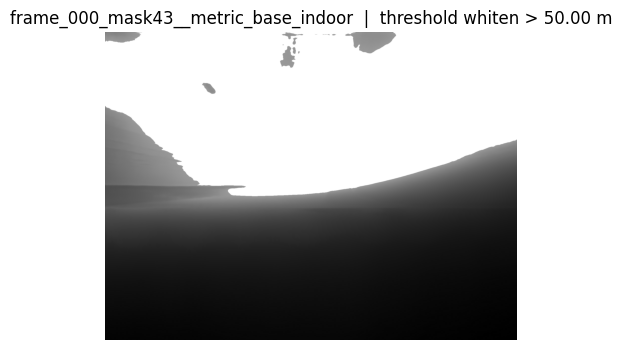

In [36]:
# --- Threshold-based whitening visualization (no widgets) ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_threshold(image_model_base: str, threshold: float):
    """
    image_model_base: filename stem without .npy
                      e.g. "frame_000__metric_base_outdoor"
    threshold        : values ABOVE this will be whitened
    """
    npy_path = RAW_OUTPUT_DIR / f"{image_model_base}.npy"
    if not npy_path.exists():
        raise FileNotFoundError(f"No depth file found: {npy_path}")

    depth_raw = np.load(npy_path).astype(np.float32)

    # Create a visualization copy so we never modify raw data
    vis = depth_raw.copy()

    # Apply whitening: values > threshold become maximum
    vis[vis > threshold] = vis.max()

    # Normalize for grayscale display
    dmin, dmax = float(vis.min()), float(vis.max())
    if dmax > dmin:
        depth_norm = (vis - dmin) / (dmax - dmin)
    else:
        depth_norm = np.zeros_like(vis, dtype=np.float32)

    # Show visualization
    plt.figure(figsize=(6, 4))
    plt.title(f"{image_model_base}  |  threshold whiten > {threshold:.2f} m")
    plt.imshow(depth_norm, cmap="gray")
    plt.axis("off")
    plt.show()


# --- List available depth maps and run once ---

all_npy = sorted(RAW_OUTPUT_DIR.glob("*.npy"))
choices = [p.stem for p in all_npy]

print("Depth maps available:", len(choices))
for name in choices:
    print("  ", name)

# >>> Edit these two lines to switch file / threshold <<<
image_model_base = "frame_000_mask43__metric_base_indoor"  # pick one from the list above
threshold = 50                                     # meters; change and re-run to see effect

visualize_threshold(image_model_base, threshold)


In [27]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [28]:
import notebook
import jupyterlab
notebook.__version__, jupyterlab.__version__

('7.5.0', '4.5.0')